In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import requests
import torch
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from transformers import (BitsAndBytesConfig, AutoProcessor,
                          LlavaForConditionalGeneration, GenerationConfig)

/anaconda/envs/dpml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
df4 = pd.read_pickle("/home/student/HallucinationsLLM/df.pkl")
df5 = pd.read_excel("/home/student/HallucinationsLLM/team5_clean_dataset.xlsx", index_col=0)

In [3]:
image_overlap = list(set(df4.index).intersection(df5['image_link']))

In [32]:
def get_max_key_value(d):
    if d:
        max_key = max(d, key=d.get)
        return max_key, d[max_key]
    else:
        return None, None

def process_df4(df):
    df['hallucinations'].fillna(df['hillucination_text'], inplace=True)
    df = df.drop('hillucination_text', axis=1)
    df['image_link'] = df.index
    df = df.reset_index(drop=True)
    for i in range(1,5):
        df[[f'pred_{i}', f'pred_{i}_prob']] = df[f'pred_{i}'].apply(lambda x: pd.Series(get_max_key_value(x)))
    
    df.rename(columns={'text': 'description', 'generated_logits': 'logits'}, inplace=True)
    df['temperature'] = 0.7
    return df

In [33]:
df4 = process_df4(df4)
df = pd.concat([df4, df5]).reset_index(drop=True)

NameError: name 'process_df4' is not defined

In [15]:
df = df5

In [2]:
model_name = 'llava-hf/llava-1.5-7b-hf'
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.bfloat16)

model = LlavaForConditionalGeneration.from_pretrained(model_name,
                                                      quantization_config=quantization_config)
processor = AutoProcessor.from_pretrained(model_name)

/anaconda/envs/dpml_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]
/anaconda/envs/dpml_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Load Data

## EDA

In [16]:
def validate_brackets(string):
    counter = 0
    for c in string: 
        if c == "[":
            counter += 1 
        elif c == "]":
            counter -= 1
        if counter < 0 or counter > 1:
            return False 
    return True

In [17]:
def count_brackets(string):
    counter = 0
    for c in string: 
        if c == "[":
            counter += 1 
    return counter

In [18]:
def validate_spaces(s):
    if "[" not in s:
        return True
    matches = re.finditer(r'\[.*?\]', s)
    for match in matches:
        start, end = match.span()
        # Check character before the match
        if start > 0 and s[start - 1].isalpha():
            return False
        # Check character after the match
        if end < len(s) and s[end].isalpha():
            return False
    return True

In [19]:
cols_with_brackets = ['hallucinations', 'hedges', 'context_1', 'context_2', 'context_3', 'context_4']
for col in cols_with_brackets:
    validation_result = df[col].apply(lambda x: validate_brackets(x))
    passed_num = validation_result.astype(int).sum() 
    valid_spaces = df[col].apply(validate_spaces)
    valid_space_num = valid_spaces.astype(int).sum() 
    if passed_num != len(df):
        print(f"{col} validation test failed: {passed_num}")
        print("indexes", validation_result[validation_result == False].index.tolist())
    if valid_space_num != len(df):
        print(f"{col} space test failed: {valid_space_num}")
        print("indexes", valid_spaces[valid_spaces == False].index.tolist())

In [20]:
cols_with_brackets = ['hallucinations', 'hedges', 'context_1', 'context_2', 'context_3', 'context_4']
for col in cols_with_brackets:
    df[f'{col}_count'] = df[col].apply(lambda x: count_brackets(x))

Text(0.5, 1.0, '#Hallucinations Distriubtion')

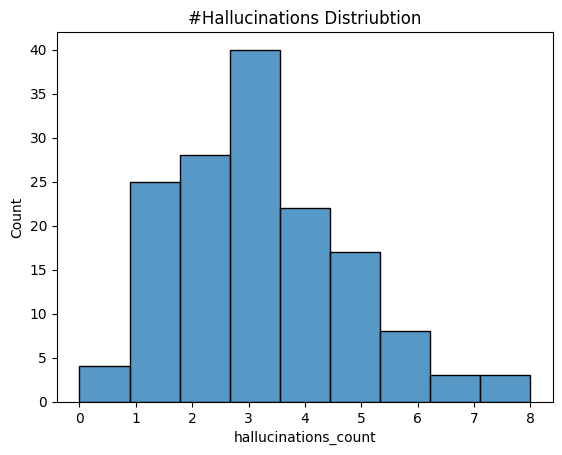

In [21]:
sns.histplot(data=df, x='hallucinations_count', bins=9)
plt.title("#Hallucinations Distriubtion")

In [22]:
import re
import ast
def clean_text(text):
    # Remove specific substrings
    text = re.sub(r'<0x0A>', ' ', text)
    text = re.sub(r'</s>', '', text)
    # Remove any other unwanted patterns (adjust the regex if needed)
    text = re.sub(r'<[^>]*>', '', text)
    return text.strip()

def count_words(text):
    words = text.split()
    return len(words)


def first_brackets_index(text):
    cleaned_text = clean_text(text)
    words = cleaned_text.split()
    for i, word in enumerate(words):
        if "[" in word:
            return i / len(words)
    return -1 

def extract_brackets_len(text):
    lens = []
    cleaned_text = clean_text(text)
    words = cleaned_text.split()
    for i, word in enumerate(words):
        if "[" in word:
            counter = 0
            for j in range(i, len(words)):
                counter += 1
                if "]" in words[j]:
                    break
            lens.append(counter)
    return lens

def get_words_dist(description, logits):
    cleaned_text = clean_text(description)
    words = cleaned_text.split()
    probs = {}
    print(len(words), len(logits))
    assert len(words) == len(logits)
    for word, prob_dict in zip(words, logits):
        probs[word] = prob_dict[word]
    return probs

df['logits'] = df['logits'].apply(lambda x: ast.literal_eval(x))
df['clean_description'] = df['description'].apply(clean_text)
df['description_len'] = df['clean_description'].apply(count_words)
df['first_hal_index'] = df['hallucinations'].apply(first_brackets_index)
df['hal_lens'] = df['hallucinations'].apply(extract_brackets_len)

In [23]:
hal_lens = []
for len_list in df['hal_lens'].values:
    hal_lens.extend(len_list)

print(pd.Series(hal_lens).value_counts())

def is_max_greater_than_2(lst):
    if len(lst) == 0:
        return False
    return max(lst) >= 2

df[df['hal_lens'].apply(is_max_greater_than_2)].index

1     353
2      60
3      23
4      14
5       7
9       4
8       2
7       2
13      1
6       1
Name: count, dtype: int64


Index([  1,   3,  13,  14,  32,  33,  36,  41,  43,  44,  45,  50,  51,  53,
        54,  58,  59,  60,  61,  64,  65,  66,  68,  69,  70,  72,  74,  75,
        77,  78,  79,  81,  82,  84,  85,  87,  88,  89,  90,  91,  92,  93,
        94,  97,  99, 103, 104, 105, 107, 108, 110, 111, 112, 113, 114, 117,
       119, 120, 123, 124, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139,
       140, 143, 145, 147],
      dtype='int64')

In [24]:
def logits_len_1(logits):
    one_logit = []
    for word, probs in logits:
        if len(probs) == 1: 
            one_logit.append(word)
    return one_logit

In [25]:
df['one_logit'] = df['logits'].apply(lambda x: logits_len_1(x))

In [26]:
df['one_logit']

0      [ict, s, ively, ant, ying, ust, ling, ous,  of...
1      [ust, ling, ids, ably, s, x, ed, ulated, est, ...
2      [m, in, is, cent,  of,  R, ings, cess, aring, ...
3      [ict, s, zy,  by, ed, ying, x, ps, ls, s,  be,...
4                     [ict, s, ry,  of, cape,  of,  the]
                             ...                        
145    [ict, s, ining,  of,  them,  of, ps, ps, x, ,,...
146    [iding, icy, cle, er, icy, cle,  the,  be, ott...
147               [ures, x, ire, all, ,, ve, ys, coming]
148            [ress, es, ments, ress,  of, c, asing, .]
149    [ray, s,  of, aring, ed, cks, ers, x,  of, ati...
Name: one_logit, Length: 150, dtype: object

Text(0.5, 1.0, 'First Hallucination normalized Location Distribution')

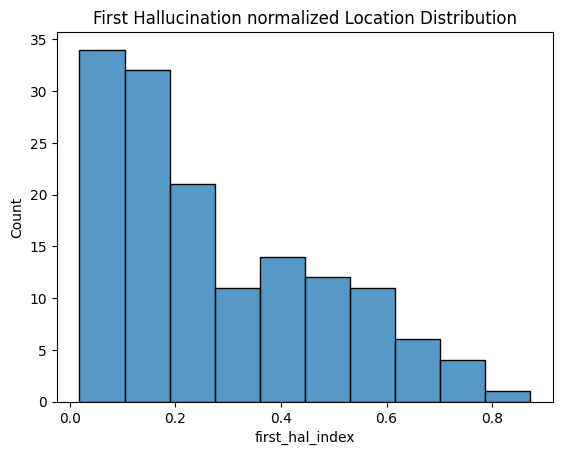

In [27]:
filtered_df = df[df['first_hal_index'] != -1]
sns.histplot(data=filtered_df, x='first_hal_index', bins=10)
plt.title("First Hallucination normalized Location Distribution")

In [28]:
pearsonr(df['description_len'], df['hallucinations_count'])

PearsonRResult(statistic=np.float64(0.2927831185409878), pvalue=np.float64(0.00027706021284601347))

In [29]:
pearsonr(df['hedges_count'], df['hallucinations_count'])

PearsonRResult(statistic=np.float64(0.09395551276018249), pvalue=np.float64(0.25278091444363826))

In [30]:
new_data = {
    'probe_number': [],
    'pred': [],
    'label': [],
    'prob': []
}

# Loop through each column group and append to new_data
for i in range(1, 5):
    new_data['probe_number'].extend([i] * len(df))
    new_data['pred'].extend(df[f'pred_{i}'])
    new_data['label'].extend(df[f'label_{i}'])
    new_data['prob'].extend(df[f'pred_{i}_prob'])

# Create the new DataFrame
new_df = pd.DataFrame(new_data)
new_df['correct_pred'] = (new_df['pred'] == new_df['label']).astype(int)
correct_df = new_df[new_df['correct_pred'] == 1]
wrong_df = new_df[new_df['correct_pred'] == 0]

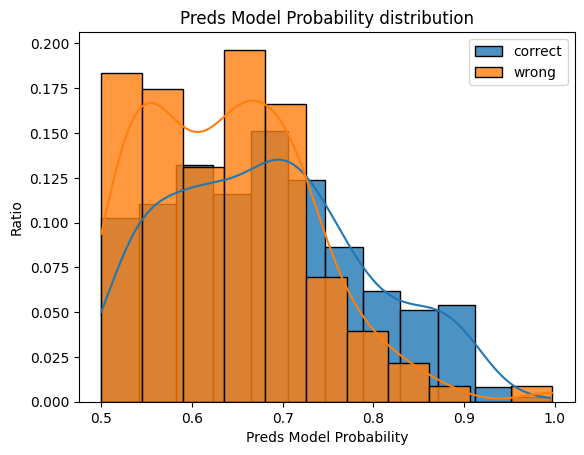

In [31]:
sns.histplot(data=correct_df, x="prob", kde=True, stat='probability', label="correct", alpha=0.8)
sns.histplot(data=wrong_df, x="prob", kde=True, stat='probability', label="wrong", alpha=0.8)
plt.legend()
plt.xlabel('Preds Model Probability')
plt.ylabel('Ratio')
plt.title("Preds Model Probability distribution")
plt.show()

In [32]:
def map_words_logits(logits, description):
    pattern = r'<0x0A>|</s>'
    cleaned_description = re.sub(pattern, ' ', description)
    cleaned_description = re.sub(r'\s+', ' ', cleaned_description).strip()
    words = cleaned_description.split(" ")
    words_logits_indices = []
    idx = 0 
    words_token = ""
    idx_list = []
    flag = False
    for i, (token, prob_dict) in enumerate(logits):
        if ">" == token[-1]:
            flag = False
            continue
        if "<" in token:
            flag = True
        if flag:
            continue
        
        if token.strip() == ".":
            continue
        if words[idx][-1] == "." and token.strip()[-1] != ".":
            word = words[idx][:-1]
        else:
            if "." in words[idx]: 
                print(words[idx])
            word = words[idx]
        # print(i, idx, token.strip(), word, words_token)
        if token.strip() == word:
            words_logits_indices.append((word.replace(".", ""), [i]))
            idx += 1 
        else:
            words_token += token.strip()
            idx_list.append(i)
            if words_token == word:
                words_logits_indices.append((word.replace(".", ""), idx_list))
                words_token = ""
                idx_list = []
                idx += 1 
    return words_logits_indices

In [33]:
def check(logits):
    tokens = []
    for token, _ in logits: 
        if "<" in token or ">" in token:
            tokens.append(token)
    return list(set(tokens))

In [34]:
lst = df['logits'].apply(check).tolist()
flattened_list = [item for sublist in lst for item in sublist]
set(flattened_list)

{' <', '.<', '</s>', '>', '><'}

In [35]:
df['words_logits_mapping'] = df.apply(lambda row: map_words_logits(row['logits'], row['description']), axis=1)

coffee).


In [36]:
def dot_in_hal(text):
    lens = []
    cleaned_text = clean_text(text)
    words = cleaned_text.split()
    for i, word in enumerate(words):
        if "[" in word:
            counter = 0
            for j in range(i, len(words)):
                counter += 1
                if "." in words[j]:
                    print(words[j])
                if "]" in words[j]:
                    break
            lens.append(counter)
    return lens

In [37]:
x = df['hallucinations'].apply(dot_in_hal)

[group].
dogs].
[back].
[frisbee].
[frisbee].
[arms].
[seated].
[water].
ball].
[rain].
conditions].
bowl].
[nose].
positions].
[backpack].
musician].
[dishes].
[rice].
[bench].
[runway].
[paintbrush].
[airplane].
air].
fruits].
open].
cups].
space].
[kneeling].
[boys].
table].
[backpacks].
witch].
light].
[road].
edge].
furniture].
[upwards].
[ball].
windows].
[wallpaper].
[turn].
controller].
bowls].
fish].
wrist].
[flags].
dishes].
[pedestrians].
[wall].
road].
phone].
turned].


In [38]:
def get_in_out_indices(sentences):
    results = []
    for sentence in sentences:
        in_indices = []
        out_indices = []
        words = sentence.split()
        in_brackets = False
        for i, word in enumerate(words):
            if '[' in word:
                in_brackets = True
            if ']' in word:
                in_brackets = False

            if in_brackets or '[' in word or ']' in word:
                in_indices.append(i)
            else:
                out_indices.append(i)
        results.append({'in': in_indices, 'out': out_indices})
    return results

In [39]:
def extract_hals_probs(logits, words_logits_mapping, hallucinations):
    pattern = r'<0x0A>|</s>'
    cleaned_hallucinations = re.sub(pattern, ' ', hallucinations)
    cleaned_hallucinations = re.sub(r'\s+', ' ', cleaned_hallucinations).strip()
    sentences = cleaned_hallucinations.split(".")[:-1]
    in_out_probs_list = []
    counter = 0 
    in_out_indices = get_in_out_indices(sentences)
    for in_out_dict, sentence in zip(in_out_indices, sentences): 
        words = sentence.split()
        sentence_dict = {"out": {"min": None, "max": None, "mean": None}, "in": {"min": None, "max": None, "mean": None}}
        # in part 
        in_indices = in_out_dict['in']
        if len(in_indices) > 0:
            in_probs = []
            for j in in_indices:
                try:
                    word_item = words_logits_mapping[j + counter]
                except:
                    # print(logits)
                    print(sentence)
                    print(words[j])
                    print(words_logits_mapping)
                    print(len(words_logits_mapping), j + counter)
                    return None
                prob_idx = word_item[1][0]
                prob = logits[prob_idx][1][logits[prob_idx][0].strip()]
                in_probs.append(prob)
            
            sentence_dict["in"]["min"] = min(in_probs)
            sentence_dict["in"]["max"] = max(in_probs)
            sentence_dict["in"]["mean"] = sum(in_probs) / len(in_probs)

        # out part 
        out_indices = in_out_dict['out']
        if len(out_indices) > 0:
            out_probs = []
            for j in out_indices:
                try:
                    word_item = words_logits_mapping[j + counter]
                except:
                    # print(logits)
                    print(sentence)
                    print(words[j])
                    print(words_logits_mapping)
                    print(len(words_logits_mapping), j + counter)
                    return None
                prob_idx = word_item[1][0]
                prob = logits[prob_idx][1][logits[prob_idx][0].strip()]
                out_probs.append(prob)
            
            sentence_dict["out"]["min"] = min(out_probs)
            sentence_dict["out"]["max"] = max(out_probs)
            sentence_dict["out"]["mean"] = sum(out_probs) / len(out_probs)

        counter += len(words)
        in_out_probs_list.append(sentence_dict)
    return in_out_probs_list

In [40]:
df['in_out_probs'] = df.apply(lambda row: extract_hals_probs(row['logits'], row['words_logits_mapping'], row['hallucinations']), axis=1)

In [41]:
df['in_out_probs']

0      [{'out': {'min': 0.0053, 'max': 0.9803, 'mean'...
1      [{'out': {'min': 0.0158, 'max': 0.9954, 'mean'...
2      [{'out': {'min': 0.0062, 'max': 0.9999, 'mean'...
3      [{'out': {'min': 0.1675, 'max': 0.9998, 'mean'...
4      [{'out': {'min': 0.0184, 'max': 0.9999, 'mean'...
                             ...                        
145    [{'out': {'min': 0.0926, 'max': 0.9961, 'mean'...
146    [{'out': {'min': 0.0121, 'max': 0.9575, 'mean'...
147    [{'out': {'min': 0.0348, 'max': 0.9541, 'mean'...
148    [{'out': {'min': 0.0018, 'max': 0.9147, 'mean'...
149    [{'out': {'min': 0.0681, 'max': 0.9998, 'mean'...
Name: in_out_probs, Length: 150, dtype: object